In [1]:
from rampwf.utils import assert_read_problem
import numpy as np
import os

from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import matplotlib.pyplot as plt
np.random.seed(42)

from problem0 import get_train_data, get_test_data


In [2]:
## Testing the old Read the data ~ 1min45
X_train, Y_train = get_train_data()
len(X_train), len(Y_train)


(15000, 15000)

In [46]:
## Free memory
del X_train, Y_train

((3000, 64, 64), (3000, 16384))

In [3]:
max_H= np.max([x.shape[0] for x in X_train])
min_H= np.min([x.shape[0] for x in X_train])
max_W= np.max([x.shape[1] for x in X_train])
min_W= np.min([x.shape[1] for x in X_train])

In [4]:
max_H, min_H, max_W, min_W

(1705, 155, 640, 640)

In [5]:
## Define the transforms for the data
transforms_train_X = transforms.Compose([
    transforms.Resize((128,128)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ## Imagenet mean and std
    transforms.Grayscale(num_output_channels=1),
])
transforms_train_Y = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
])

In [11]:
## convert the data to tensors and normalize
X_train_tensor = [torch.from_numpy(x).permute(2,0,1) for x in tqdm(X_train)]
Y_train_tensor = [torch.from_numpy(x).permute(2,0,1) for x in tqdm(Y_train)]

100%|██████████| 15000/15000 [00:00<00:00, 147273.63it/s]


In [12]:
X_train_tensor[0].shape, Y_train_tensor[0].shape

(torch.Size([3, 360, 640]), torch.Size([3, 72, 128]))

In [13]:
## We now define a customized dataset class
## With transforms for X and Y, to scale all images to the same size 
class Dataset_custom(Dataset):
    def __init__(self, X, Y, transform_X=None, transform_Y=None):
        self.X = X
        self.Y = Y
        self.transform_X = transform_X
        self.transform_Y = transform_Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.transform_X:
            x = self.transform_X(x)
            x = x.squeeze(0)
            x = (x/255).float()
        if self.transform_Y:
            y = self.transform_Y(y)
            y = y.squeeze(0)
            y = (y/255).float()
        return x, y

In [14]:
train_dataset = Dataset_custom(X_train_tensor, Y_train_tensor, transforms_train_X, transforms_train_Y)
train_dataset[88][0].shape, train_dataset[88][1].shape

(torch.Size([128, 128]), torch.Size([64, 64]))

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [17]:
## Check a sample batch
X, Y = next(iter(train_loader))

In [18]:
X.shape, Y.shape

(torch.Size([32, 128, 128]), torch.Size([32, 64, 64]))

In [19]:
## Generate the numpy dataset and store them to .npy files (this takes a while ~ 5 minutes)  

X_train_np = [item[0].numpy() for item in tqdm(train_dataset)]
Y_train_np = [item[1].numpy() for item in tqdm(train_dataset)]


100%|██████████| 15000/15000 [03:50<00:00, 65.06it/s] 


In [20]:
X_train_np = np.stack(X_train_np, axis=0)
Y_train_np = np.stack(Y_train_np, axis=0)
X_train_np.shape, Y_train_np.shape

((15000, 128, 128), (15000, 64, 64))

In [21]:
X_train_np.min(), X_train_np.max(), Y_train_np.min(), Y_train_np.max()

(0.0, 0.99607843, 0.0, 0.99607843)

In [33]:
# np.save('X_train.npy', X_train_np)
# np.save('Y_train.npy', Y_train_np)

In [34]:
## We check the loading to verify that everything is fine
# X, Y = np.load('X_train.npy'), np.load('Y_train.npy')

In [35]:
# X.shape, Y.shape

((15000, 320, 320, 3), (15000, 64, 64, 3))

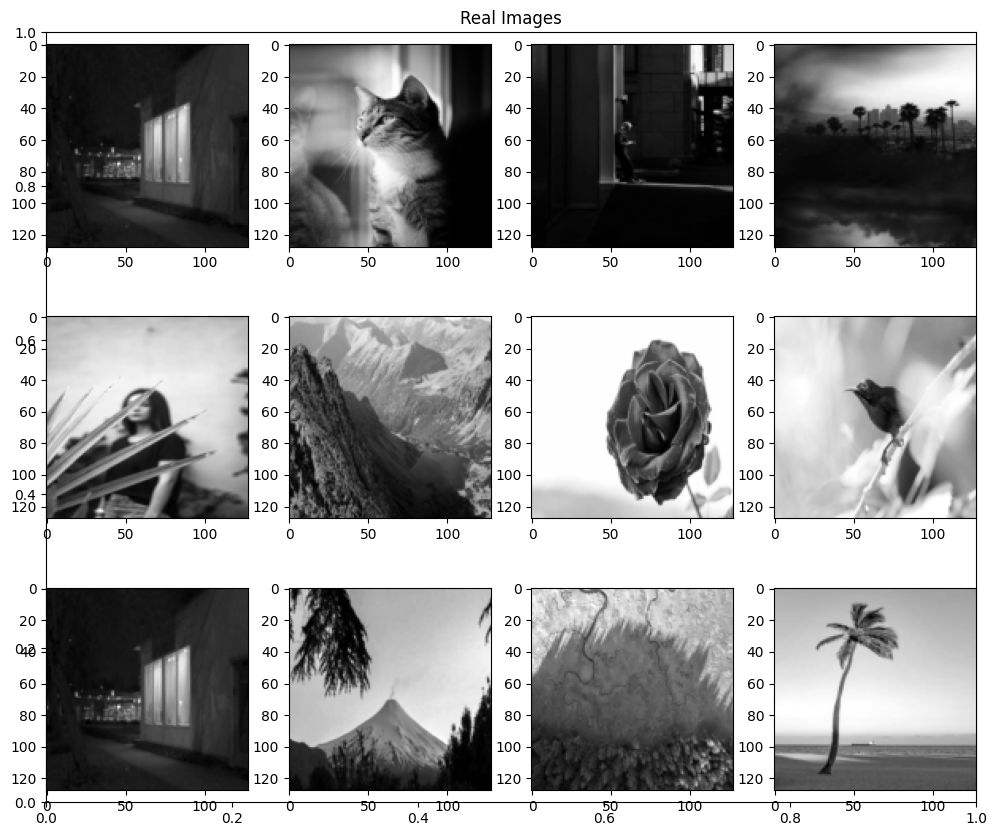

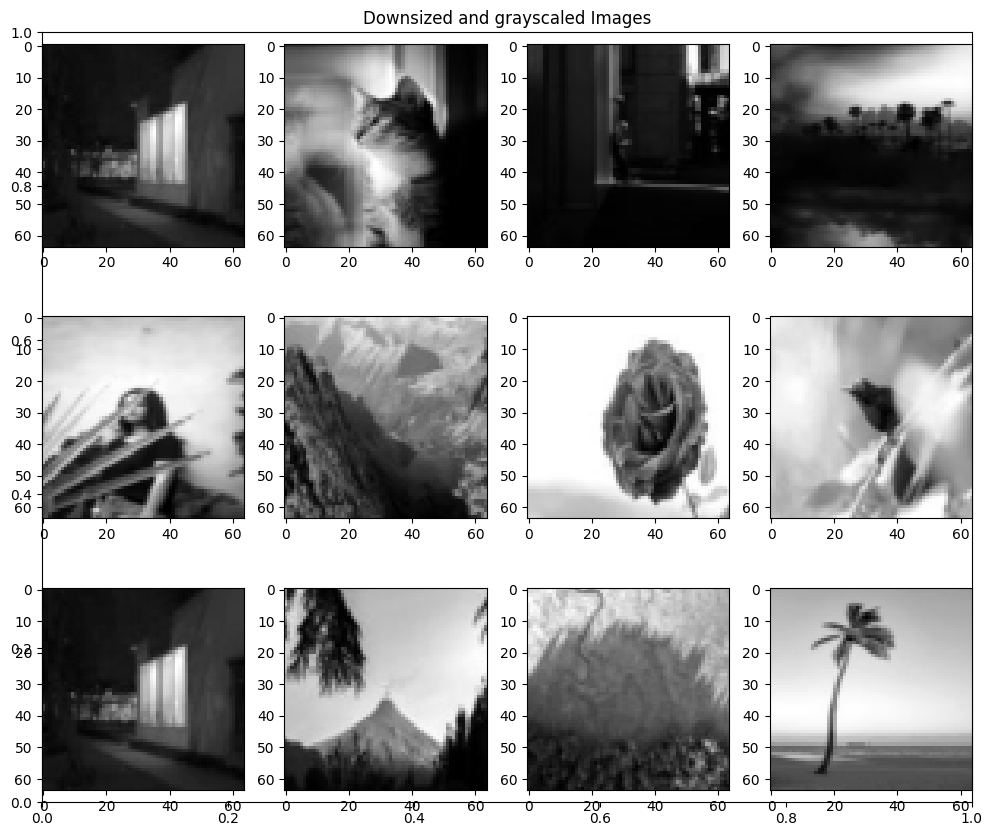

In [22]:
## Plot 12 images from the dataset with their target images

indices = np.random.randint(0, 128, 12)

plt.figure(figsize=(12, 10))
plt.title('Real Images')
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_train_np[idx], cmap='gray')
plt.show()

plt.figure(figsize=(12, 10))
plt.title('Downsized and grayscaled Images')
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(Y_train_np[idx], cmap='gray')
plt.show()



(254, 0, 254, 0)

In [23]:
## We now split the data into 4 : data/X_train.npy, data/Y_train.npy, 
# data/X_test.npy, data/Y_test.npy, 
# data/public/X_train.npy, data/public/Y_train.npy, 
# data/public/X_test.npy, data/public/Y_test.npy 

## Shuffle the data
indices = np.random.permutation(X_train_np.shape[0]) ## Or maybe not lol... 

## split the indices into 4 sets : 40%, 10%, 40%, 10%
split1 = 3000 ## train private = 3000
split2 = 3500 ## test private = 500
split3 = 6500 ## train public = 3000
split4 = 7000 ## test public = 500

## We swap X and Y because X are actually the targets and Y are the inputs
X_train_private, Y_train_private = Y_train_np[indices[:split1]], X_train_np[indices[:split1]]
X_test_private, Y_test_private = Y_train_np[indices[split1:split2]], X_train_np[indices[split1:split2]]
X_train_public, Y_train_public = Y_train_np[indices[split2:split3]], X_train_np[indices[split2:split3]]
X_test_public, Y_test_public = Y_train_np[indices[split3:split4]], X_train_np[indices[split3:split4]]



In [24]:
X_train_private.shape, Y_train_private.shape, X_test_private.shape, Y_test_private.shape, X_train_public.shape, Y_train_public.shape, X_test_public.shape, Y_test_public.shape

((3000, 64, 64),
 (3000, 128, 128),
 (500, 64, 64),
 (500, 128, 128),
 (3000, 64, 64),
 (3000, 128, 128),
 (500, 64, 64),
 (500, 128, 128))

In [25]:
## Save the data to .npy files

if not os.path.exists('data'):
    os.makedirs('data')
    os.makedirs('data/public')

In [26]:
np.save('data/Xtrain.npy', X_train_private)
np.save('data/Ytrain.npy', Y_train_private)
np.save('data/Xtest.npy', X_test_private)
np.save('data/Ytest.npy', Y_test_private)
np.save('data/public/Xtrain.npy', X_train_public)
np.save('data/public/Ytrain.npy', Y_train_public)
np.save('data/public/Xtest.npy', X_test_public)
np.save('data/public/Ytest.npy', Y_test_public)

In [27]:
del X_train_np, Y_train_np, X_train_private, Y_train_private, X_test_private, Y_test_private, X_train_public, Y_train_public, X_test_public, Y_test_public

In [28]:
## Finally test with problem.get_train_data and problem.get_test_data

problem = assert_read_problem()
X_train_final, Y_train_final = problem.get_train_data()
X_train_final.shape, Y_train_final.shape

((3000, 64, 64), (3000, 16384))

In [30]:
X_train_final.max()

0.99607843